# 1Dイジング模型

ここでは次の1次元強磁性ハイゼンベルグ模型を考えます。

$$
\mathcal{H} = -\sum_i S_i S_{i+1}.
$$

前章の解説に従って、$i$番目のスピンを更新するとき、
2つの状態間のエネルギー差は$\Delta E = E_\uparrow - E_\downarrow = - 2h$
と計算出来ます。
ここで、$h = S_{i-1} + S_{i+1}$は$i$番目のサイト以外のスピンが、$i$番目のスピンに及ぼす有効磁場です。
最後に、$1/(1+\exp(\beta \Delta E ))$の確率で、$S_i=1$を採択します。

なお、指数関数の計算は重いので（かけ算とかに比べ）、予め指数関数の値は計算して保存しておきます。

In [2]:
@show VERSION
using BenchmarkTools, Random

VERSION = v"1.5.2"


## 最初の実装
以下の実装を見てみましょう。ising1d!という関数は、スピンあたりniters回のスピン更新を行います。
関数は最初に呼び出した時にコンパイルされます。
実行速度を正しく計測するには、一回呼び出してからにしましょう。
BenchmarkTools中の@benchmarkを使えば、自動的に複数回呼び出して計測してくれます。

### 演習問題

毎回指数関数の値を計算する場合、どの程度性能が悪化するか確認してみましょう。

In [3]:
function ising1d!(s, β, niters, rng)
    n = length(s)
    min_h = -2
    max_h = 2
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
    end
end

num_spins = 100
rng = MersenneTwister(4649)
s0 = rand(rng, Int8[-1, 1], num_spins)
β = 100.0
niters = 10^3

s = copy(s0)

# Run once to compile the function
ising1d!(s, β, niters, rng)

@time ising1d!(s, β, niters, rng)
@benchmark ising1d!(s, β, niters, rng) setup=(s = copy(s0))

  0.000489 seconds (1 allocation: 128 bytes)


BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  1
  --------------
  minimum time:     414.248 μs (0.00% GC)
  median time:      443.680 μs (0.00% GC)
  mean time:        486.341 μs (0.00% GC)
  maximum time:     1.401 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

## 物理量計測込みの実装

では、次に物理量（磁化、エネルギー)の計算を含めたプログラムを書いてみます。
ここで重要な点は、磁化、エネルギーの値は、スピン状態の更新と同時に、差分で更新する点です。
この更新は、(スピン更新と同じ)$O(1)$の計算量ですみますが、
定義に従って最初から計算し直すと$O(N)$の計算量がかかってしまいます。

以下のコードはmodule MCの中に囲っています。
moduleの中に入れない場合、構造体structの再定義が許されないため、
コードを書くときの試行錯誤の妨げになるからです。

SpinStateはスピン状態を表すstructで、磁化、エネルギーの値も同時に保存しています。
スピン状態やこれらの物理量が常にconsistentであることを保証して計算を進めます。

エネルギー、磁化を計算する関数をそれぞれ定義し、SpinStateオブジェクトの生成、
状態更新前後のconsistencyのチェックに利用しています。

In [4]:
# Wrap everything with a module to allow redefition of type
module MC

"""
Composite type to represent a spin state
"""
mutable struct SpinState
    num_spins::Int
    s::Array{Int8,1}
    energy::Int
    tot_mag::Int
end

"""
Energy
"""
function energy(s)
    n = length(s)
    - sum((s[i] * s[ifelse(i == n, 1, i+1)] for i in 1:n))
end

"""
Total magnetization
"""
total_magnetization(s) = sum(s)

"""
Constructor
"""
function SpinState(s)
    ss = SpinState(length(s), copy(s), energy(s), total_magnetization(s))
    sanity_check(ss)
    ss
end

"""
Sanity check
"""
function sanity_check(ss)
    @assert energy(ss.s) == ss.energy
    @assert total_magnetization(ss.s) == ss.tot_mag
end

"""
Take an object of SpinState as an input and update it in place.
"""
function update!(ss, β, niters, rng)
    min_h = -2
    max_h = 2
    s = ss.s
    n = ss.num_spins
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
        
        # Update observables with O(1) operations
        ss.energy += (si_old - s[i]) * h
        ss.tot_mag += (s[i] - si_old)
    end
end

end
;

では、実際にスピン更新を行って、その後consistencyが保たれているか見てみましょう。

In [5]:
ss = MC.SpinState(s0)
MC.update!(ss, β, niters, rng)
MC.sanity_check(ss)

In [5]:
@benchmark MC.update!(ss, β, niters, rng)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  1
  --------------
  minimum time:     473.917 μs (0.00% GC)
  median time:      499.894 μs (0.00% GC)
  mean time:        572.979 μs (0.00% GC)
  maximum time:     1.495 ms (0.00% GC)
  --------------
  samples:          8722
  evals/sample:     1

では、実際に物理量を計測してみます。
以下、$\langle O \rangle_\mathrm{MC}$は物理量$O$のモンテカルロ平均を表します。

熱容量:

$$
C = \frac{\langle E^2\rangle_\mathrm{MC} - \langle E\rangle_\mathrm{MC}^2}{T^2}
$$

磁化の2乗 (磁化自体の期待値は対称性から0になる):

$$
M_2 = \langle M^2\rangle_\mathrm{MC}
$$

帯磁率:

$$
\chi = \frac{\langle M^2\rangle_\mathrm{MC}}{T}
$$

前準備として、複数の物理量の計測結果を簡単に格納する"Accumulator"を作っておきましょう。

In [7]:
module Meas

struct Accumulator
    count::Dict{String,UInt64}
    data::Dict{String,Any}
end

"""
Constructor
"""
function Accumulator()
    Accumulator(Dict{String,UInt64}(), Dict{String,Any}())
end

"""
Add a sample
"""
function add!(acc::Accumulator, name::String, data)
    if !haskey(acc.count, name)
        acc.count[name] = 1
        acc.data[name] = copy(data)
    else
        acc.count[name] += 1
        acc.data[name] += data
    end
end

"""
Compuate mean
"""
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end

end


# Perform some tests
let
    acc = Meas.Accumulator()
    Meas.add!(acc, "obs1", ones(4))
    Meas.add!(acc, "obs1", 2 .* ones(4))
    Meas.add!(acc, "obs2", ones(4))
    Meas.add!(acc, "obs2", ones(4))
    @assert Meas.mean(acc, "obs1") ≈ 1.5 .* ones(4)
    @assert Meas.mean(acc, "obs2") ≈ ones(4)
end

では、実際に物理量を計算してみましょう。
niters_measモンテカルロステップ毎に、計測を実行します（1モンテカルロステップ＝全てのスピンを一回ずつ更新を試みる)。
また、平衡状態に達してから計測したいので、最初のntherm回の計測はスキップします。

In [9]:
function solve!(ss, acc, β, nsweeps, ntherm, niters_meas, rng)
    for isweep in 1:nsweeps
        MC.update!(ss, β, niters_meas, rng)
        if isweep <= ntherm
            continue
        end
        Meas.add!(acc, "E", Float64(ss.energy))
        Meas.add!(acc, "E2", Float64(ss.energy)^2)
        MC.sanity_check(ss)
    end
end


nsweeps = 100
niters_meas = 10
ntherm = ceil(nsweeps/10)
β = 1.0

ss = MC.SpinState(s0)
acc = Meas.Accumulator()
solve!(ss, acc, β, nsweeps, ntherm, niters_meas, rng)

println(Meas.mean(acc, "E"))
println(Meas.mean(acc, "E2"))

-762.1333333333333
581227.3777777777


In [11]:
using PyPlot

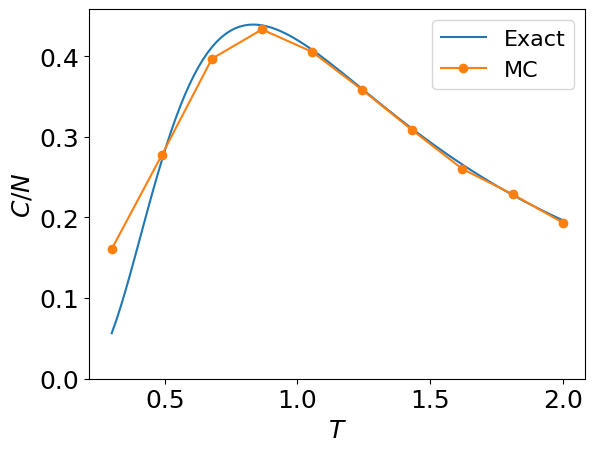

PyObject <matplotlib.legend.Legend object at 0x1551f2bb0>

In [13]:
exact_C(T) = 1/(T * cosh(1/T))^2

nsweeps = 10^4
num_spins = 1000

rng = MersenneTwister(4649)
s0 = rand(rng, Int8[-1, 1], num_spins)

Ts = range(0.3, 2, length=100)
Ts_mc = range(0.3, 2, length=10)

C_mc = Float64[]
for T in Ts_mc
    ss = MC.SpinState(s0)
    acc = Meas.Accumulator()
    solve!(ss, acc, 1/T, nsweeps, ntherm, niters_meas, rng)
    E = Meas.mean(acc, "E")
    E2 = Meas.mean(acc, "E2")
    push!(C_mc, (E2-E^2)/T^2)
end

plt.plot(Ts, exact_C.(Ts), label="Exact")
plt.plot(Ts_mc, C_mc ./ num_spins, label="MC", marker="o")
plt.xlabel(raw"$T$")
plt.ylabel(raw"$C/N$")
plt.ylim([0, nothing])
plt.legend()

TODO: 厳密解との比較